In [1]:
import ee
import geemap
import os
import pandas as pd
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import json
from utils.functions import get_files_info
from numpy.linalg import norm
GEE_PROJECT_ID = "fusion-371234"
ee.Authenticate()
ee.Initialize(project=GEE_PROJECT_ID)

plt.rcParams['font.family'] = 'Times New Roman'

# Functions

In [2]:
def compute_ndvi(img, red_idx=3, nir_idx=7):
    red = img[red_idx]
    nir = img[nir_idx]
    ndvi = (nir - red) / (nir + red + 1e-6)
    return ndvi

def get_s2_image(start, end):
    return (
        ee.ImageCollection('COPERNICUS/S2_HARMONIZED')
        .filterBounds(aoi)
        .filterDate(start, end)
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
        .sort('CLOUDY_PIXEL_PERCENTAGE')
        .first()
        .clip(aoi)
    )

def compute_mean_ndvi_timeseries(path, scale):
    n_files, name_files = get_files_info(path)
    dates = []
    mean_ndvi = []

    for file in sorted(name_files):
        date = os.path.basename(file).split("_")[1].replace(".tif", "")
        dates.append(pd.to_datetime(date))

        with rasterio.open(os.path.join(path, file)) as src:
            red = src.read(4).astype(np.float32) / scale
            nir = src.read(8).astype(np.float32) / scale

            nodata = src.nodata
            if nodata is not None:
                mask = (red == nodata) | (nir == nodata)
                red = np.where(mask, np.nan, red)
                nir = np.where(mask, np.nan, nir)

            denominator = nir + red
            ndvi = np.where(denominator != 0, (nir - red) / denominator, np.nan)

            mean_ndvi.append(np.nanmean(ndvi))

    return dates, mean_ndvi

def compute_mean_lai_timeseries(path, scale):
    n_files, name_files = get_files_info(path)
    dates = []
    mean_lai = []

    for file in sorted(name_files):
        date = os.path.basename(file).split("_")[1].replace(".tif", "")
        dates.append(pd.to_datetime(date))

        with rasterio.open(os.path.join(path, file)) as src:
            red = src.read(4).astype(np.float32) / scale
            nir = src.read(8).astype(np.float32) / scale

            nodata = src.nodata
            if nodata is not None:
                mask = (red == nodata) | (nir == nodata)
                red = np.where(mask, np.nan, red)
                nir = np.where(mask, np.nan, nir)

            denominator = nir + red
            evi = (nir - red) / (nir + red + 1e-6)

            lai = -np.log((0.69 - evi) / 0.59 + 1e-6) / 0.91
            mean_lai.append(np.nanmean(lai))

    return dates, mean_lai


# Study Area

In [118]:
Map = geemap.Map(center=[15.851, 78.056], zoom=12)
Map.add_basemap("HYBRID")

aoi = ee.Geometry.Rectangle([
    77.926, 15.723,
    78.186, 15.979
]).buffer(3000)  


before_date = ('2018-10-26', '2018-10-27')
after_date  = ('2018-11-15', '2018-11-16')

img_before = get_s2_image(*before_date)
img_after  = get_s2_image(*after_date)

ndvi_before = img_before.normalizedDifference(['B8', 'B4']).rename('NDVI')
ndvi_after  = img_after.normalizedDifference(['B8', 'B4']).rename('NDVI')
ndvi_diff   = ndvi_after.subtract(ndvi_before).rename('NDVI_diff')

rgb_vis = {
    'bands': ['B4', 'B3', 'B2'],
    'min': 0,
    'max': 3000,
    'gamma': 1.2
}

ndvi_vis = {
    'min': 0,
    'max': 1,
    'palette': ['brown', 'yellow', 'green']
}

diff_vis = {
    'min': -0.4,
    'max': 0.2,
    'palette': ['red', 'white', 'blue']
}

Map.addLayer(img_before, rgb_vis, 'Sentinel-2 RGB (Before infestation)', False)
Map.addLayer(img_after,  rgb_vis, 'Sentinel-2 RGB (After infestation)', False)

Map.addLayer(ndvi_diff,   diff_vis, 'NDVI Difference (FAW impact)', False)

Map.addLayer(aoi, {}, 'Study Area', False)  

roi_name = "india_healthy"
with open(f"rois/{roi_name}.json", "r") as f:
    pest_roi = json.load(f)

region_pest = ee.Geometry(pest_roi)
Map.addLayer(region_pest, {}, 'Pest')

Map

Map(center=[15.851, 78.056], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(child…

In [119]:
# Convert to GeoJSON format
geojson_dict = Map.user_roi.getInfo()
roi_name = "india_medium"

# Save to file
with open(f"rois/{roi_name}.json", "w") as f:
    json.dump(geojson_dict, f)

print(f"✅ Region saved as {roi_name}.json")

✅ Region saved as india_medium.json


# Before and After Pest Attack

In [120]:
S2_SR_COLLECTION_ID = "COPERNICUS/S2_HARMONIZED"
selected_bands = ['B1','B2','B3','B4','B5','B6','B7','B8','B8A','B9','B11','B12']
CLOUD_FILTER = 100
crs = "EPSG:4326"
scale = 10 

before_date = ('2018-10-20', '2018-10-26')
after_date  = ('2018-11-15', '2018-11-16')

DATE = before_date  # change to before_date if needed

condition = "medium"
roi_name = f"rois/india_{condition}"
with open(f"{roi_name}.json", "r") as f:
    region_data = json.load(f)

region = ee.Geometry(region_data)

collection = (
    ee.ImageCollection(S2_SR_COLLECTION_ID)
    .filterDate(DATE[0], DATE[1])
    .filterBounds(region)
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', CLOUD_FILTER))
    .select(selected_bands)
)

image = collection.first().clip(region)

os.makedirs("datasets/india_before_and_after", exist_ok=True)
geemap.ee_export_image(
    image,
    filename=f"datasets/india_before_and_after/{condition}_before.tif",
    scale=scale,
    region=region,
    crs=crs,
    file_per_band=False
)

print("✅ Image downloaded exactly as the region geometry.")


Generating URL ...
Please wait ...
Data downloaded to /home/fekenzofugi/Documents/rsad-time-series/datasets/india_before_and_after/medium_before.tif
✅ Image downloaded exactly as the region geometry.


In [121]:
S2_SR_COLLECTION_ID = "COPERNICUS/S2_HARMONIZED"
selected_bands = ['B1','B2','B3','B4','B5','B6','B7','B8','B8A','B9','B11','B12']
CLOUD_FILTER = 100
crs = "EPSG:4326"
scale = 10 

before_date = ('2018-10-21', '2018-10-25')
after_date  = ('2018-11-15', '2018-11-16')

DATE = after_date 

condition = "medium"
roi_name = f"rois/india_{condition}"
with open(f"{roi_name}.json", "r") as f:
    region_data = json.load(f)

region = ee.Geometry(region_data)

collection = (
    ee.ImageCollection(S2_SR_COLLECTION_ID)
    .filterDate(DATE[0], DATE[1])
    .filterBounds(region)
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', CLOUD_FILTER))
    .select(selected_bands)
)

image = collection.first().clip(region)

os.makedirs("datasets/india_before_and_after", exist_ok=True)
geemap.ee_export_image(
    image,
    filename=f"datasets/india_before_and_after/{condition}_after.tif",
    scale=scale,
    region=region,
    crs=crs,
    file_per_band=False
)

print("✅ Image downloaded exactly as the region geometry.")


Generating URL ...
Please wait ...
Data downloaded to /home/fekenzofugi/Documents/rsad-time-series/datasets/india_before_and_after/medium_after.tif
✅ Image downloaded exactly as the region geometry.


# Generate Time-Series

In [ ]:
S2_SR_COLLECTION_ID = "COPERNICUS/S2_HARMONIZED"

selected_bands = ['B1','B2','B3','B4','B5','B6', 'B7','B8','B8A','B9','B11','B12']

CLOUD_FILTER = 100
crs = "EPSG:4326"
scale = 10 

before_date = ('2018-10-25', '2018-10-26')
after_date  = ('2018-11-15', '2018-11-16')

start_date = before_date[0]
end_date   = after_date[1]

roi_name = "india_medium"
with open(f"rois/{roi_name}.json", "r") as f:
    region_data = json.load(f)

region = ee.Geometry(region_data)

collection = (
    ee.ImageCollection(S2_SR_COLLECTION_ID)
    .filterDate(start_date, end_date)
    .filterBounds(region)
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', CLOUD_FILTER))
    .select(selected_bands)
    .sort('system:time_start')
)

print("Number of images:", collection.size().getInfo())

os.makedirs(f"datasets/{roi_name}_time_series", exist_ok=True)

image_list = collection.toList(collection.size())
n_images = collection.size().getInfo()

for i in range(n_images):
    img = ee.Image(image_list.get(i))
    
    date = ee.Date(img.get('system:time_start')).format('YYYYMMdd').getInfo()
    
    filename = f"datasets/{roi_name}_time_series/S2_{date}.tif"
    
    geemap.ee_export_image(
        img.clip(region),
        filename=filename,
        scale=scale,
        region=region,
        crs=crs,
        file_per_band=False
    )
    
    print(f"✅ Exported {filename}")

print("🎉 Time-series export completed.")


# Plots

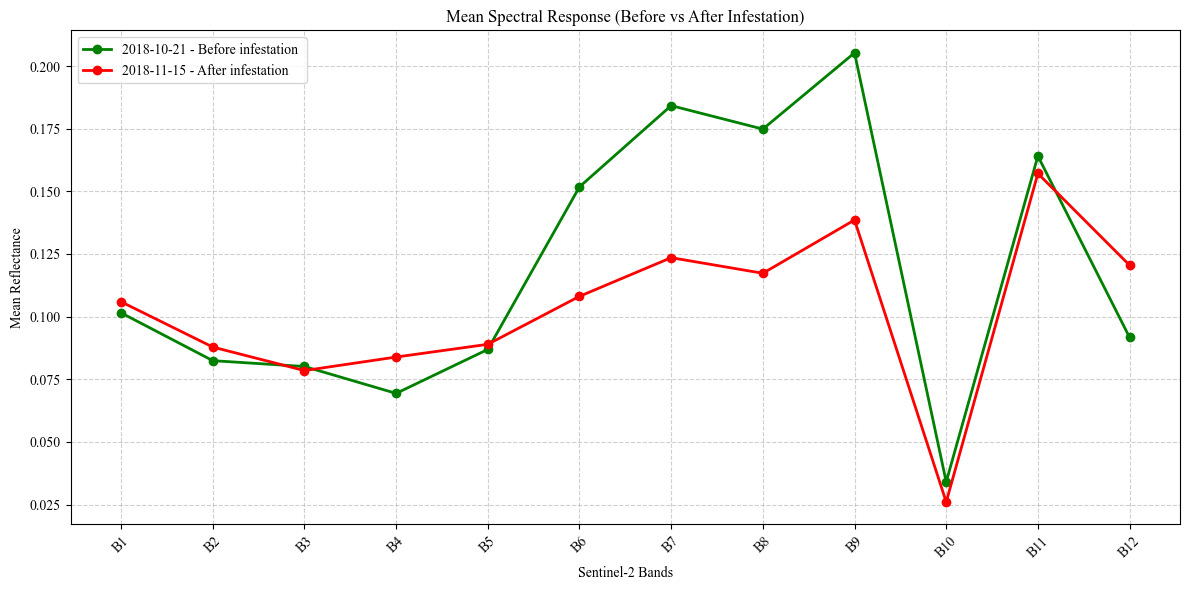

In [35]:
scale = 10000

before_date = ('2018-10-21', '2018-10-25')
after_date  = ('2018-11-15', '2018-11-16')

before_path = "datasets/india_before_and_after/severe_before.tif"
after_path  = "datasets/india_before_and_after/severe_after.tif"

with rasterio.open(before_path) as src:
    img_before = src.read() / scale
    n_bands = img_before.shape[0]

with rasterio.open(after_path) as src:
    img_after = src.read() / scale

mean_before = np.nanmean(img_before.reshape(n_bands, -1), axis=1)
mean_after  = np.nanmean(img_after.reshape(n_bands, -1), axis=1)

bands = np.arange(1, n_bands + 1)
band_labels = [f"B{i}" for i in bands]


plt.figure(figsize=(12, 6))

plt.plot(bands, mean_before, "o-", linewidth=2, label=f"{before_date[0]} - Before infestation ", color="green")
plt.plot(bands, mean_after,  "o-", linewidth=2, label=f"{after_date[0]} - After infestation ", color="red")

plt.xticks(bands, band_labels, rotation=45)
plt.xlabel("Sentinel-2 Bands")
plt.ylabel("Mean Reflectance")
plt.title("Mean Spectral Response (Before vs After Infestation)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(loc='upper left')
# plt.savefig("figures/india_spectral_response_before_after_infestation.png", dpi=300)
plt.tight_layout()
plt.show()


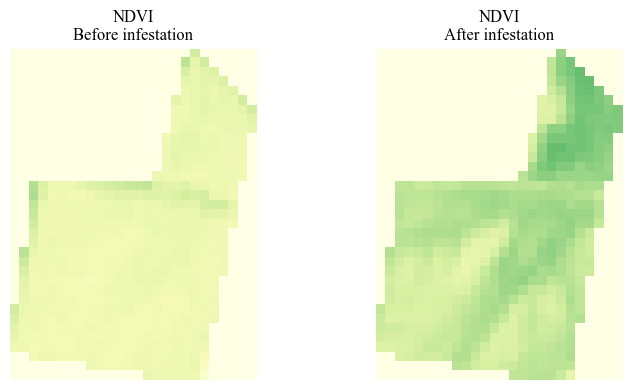

In [74]:
scale = 10000  

condition = "healthy"
before_path = f"datasets/india_before_and_after/{condition}_before.tif"
after_path  = f"datasets/india_before_and_after/{condition}_after.tif"

with rasterio.open(before_path) as src:
    img_before = src.read().astype(np.float32) / scale

with rasterio.open(after_path) as src:
    img_after = src.read().astype(np.float32) / scale

ndvi_before = compute_ndvi(img_before)
ndvi_after  = compute_ndvi(img_after)

ndvi_before = np.where(np.isfinite(ndvi_before), ndvi_before, np.nan)
ndvi_after  = np.where(np.isfinite(ndvi_after), ndvi_after, np.nan)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

ndvi_vmin, ndvi_vmax = 0, 1
cmap = "YlGn"

axes[0].imshow(ndvi_before, cmap=cmap, vmin=ndvi_vmin, vmax=ndvi_vmax)
axes[0].set_title("NDVI\nBefore infestation", fontsize=12)

axes[1].imshow(ndvi_after, cmap=cmap, vmin=ndvi_vmin, vmax=ndvi_vmax)
axes[1].set_title("NDVI\nAfter infestation", fontsize=12)

for ax in axes:
    ax.axis("off")

plt.tight_layout()
plt.show()


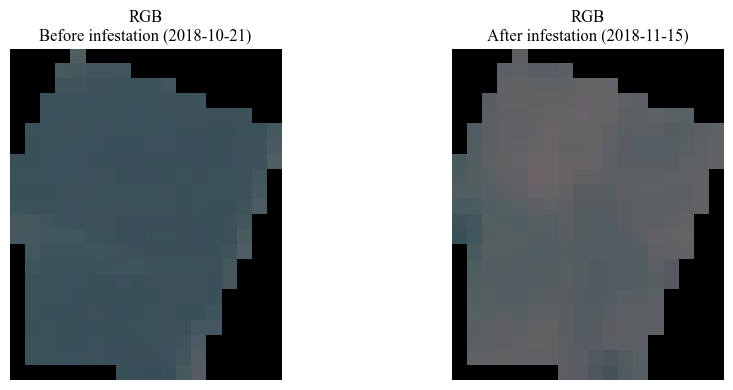

In [45]:
scale = 10000 

before_path = "datasets/india_before_and_after/medium_before.tif"
after_path  = "datasets/india_before_and_after/medium_after.tif"

def make_rgb(img, r=3, g=2, b=1, vmin=0, vmax=0.3):
    rgb = np.stack([img[r], img[g], img[b]], axis=-1)
    rgb = np.clip((rgb - vmin) / (vmax - vmin), 0, 1)
    return rgb


with rasterio.open(before_path) as src:
    img_before = src.read().astype(np.float32) / scale

with rasterio.open(after_path) as src:
    img_after = src.read().astype(np.float32) / scale

rgb_before = make_rgb(img_before)
rgb_after  = make_rgb(img_after)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].imshow(rgb_before)
axes[0].set_title(f"RGB\nBefore infestation ({before_date[0]})")

axes[1].imshow(rgb_after)
axes[1].set_title(f"RGB\nAfter infestation ({after_date[0]})")

for ax in axes:
    ax.axis("off")

plt.tight_layout()
plt.show()


Total number of files: 4


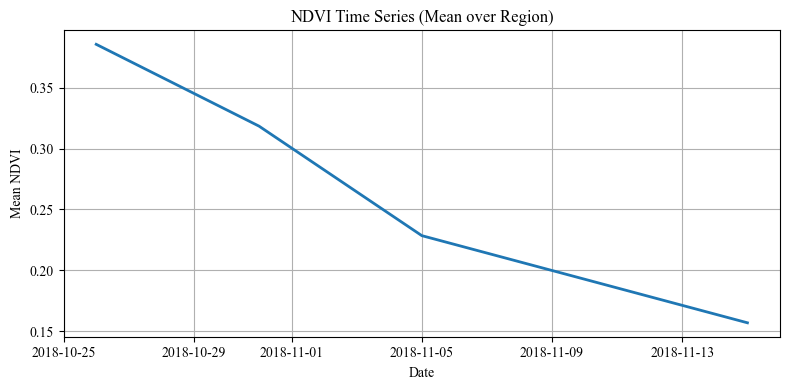

In [ ]:
scale = 10000
path = "datasets/india_pest_time_series"

n_files, name_files = get_files_info(path)

dates = []
mean_ndvi = []

for file in sorted(name_files):
    date = os.path.basename(file).split("_")[1].replace(".tif", "")
    
    with rasterio.open(f"{path}/" + file) as src:
        red = src.read(4) / scale
        nir = src.read(8) / scale
        
        nodata = src.nodata
        
        if nodata is not None:
            mask = (red == nodata) | (nir == nodata)
            red = np.where(mask, np.nan, red)
            nir = np.where(mask, np.nan, nir)
        
        denominator = nir + red
        ndvi = np.where(denominator != 0, (nir - red) / denominator, np.nan)
        
        mean_ndvi.append(np.nanmean(ndvi))
        dates.append(pd.to_datetime(date))

plt.figure(figsize=(8, 4))
plt.plot(dates, mean_ndvi, linewidth=2)
plt.xlabel("Date")
plt.ylabel("Mean NDVI")
plt.title("NDVI Time Series (Mean over Region)")
plt.grid(True)
plt.tight_layout()
plt.show()




Total number of files: 4


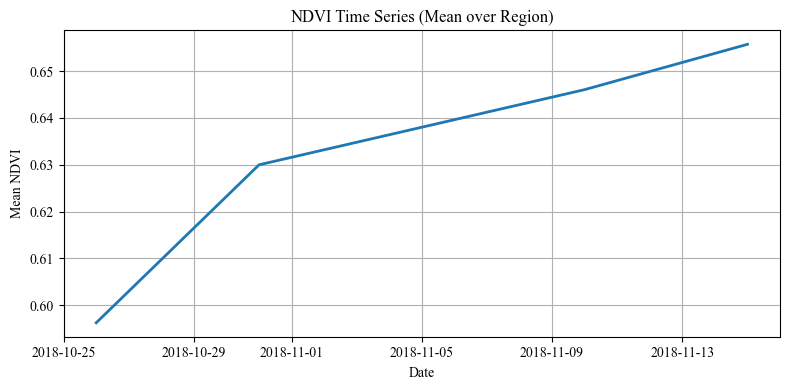

In [18]:
scale = 10000
path = "datasets/india_healthy_time_series"

# Your working function
n_files, name_files = get_files_info(path)

dates = []
mean_ndvi = []

for file in sorted(name_files):
    # Extract date from filename (adapt if needed)
    date = os.path.basename(file).split("_")[1].replace(".tif", "")
    
    with rasterio.open(path + "/" + file) as src:
        # FIX: Use .read() method instead of indexing
        red = src.read(4) / scale
        nir = src.read(8) / scale
        
        nodata = src.nodata
        
        if nodata is not None:
            mask = (red == nodata) | (nir == nodata)
            red = np.where(mask, np.nan, red)
            nir = np.where(mask, np.nan, nir)
        
        denominator = nir + red
        ndvi = np.where(denominator != 0, (nir - red) / denominator, np.nan)
        
        mean_ndvi.append(np.nanmean(ndvi))
        dates.append(pd.to_datetime(date))

plt.figure(figsize=(8, 4))
plt.plot(dates, mean_ndvi, linewidth=2)
plt.xlabel("Date")
plt.ylabel("Mean NDVI")
plt.title("NDVI Time Series (Mean over Region)")
plt.grid(True)
plt.tight_layout()
plt.show()

Total number of files: 4
Total number of files: 4


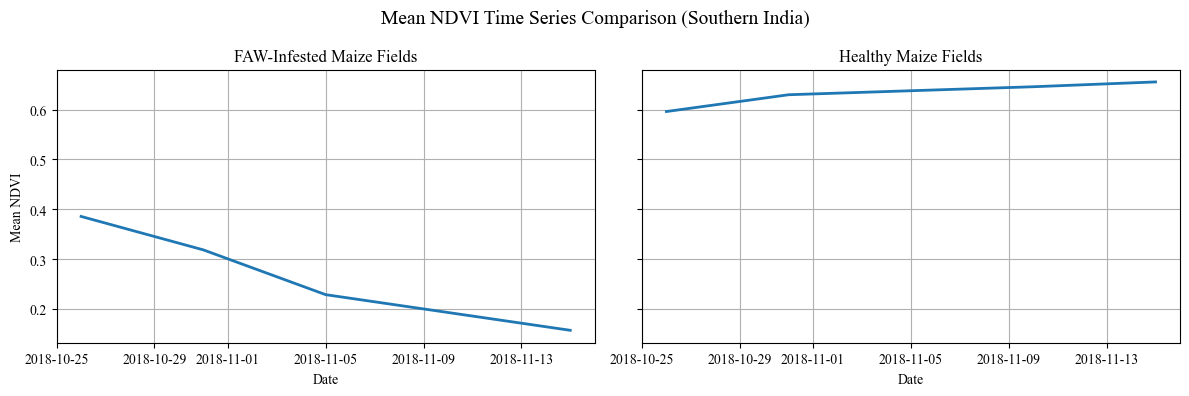

In [38]:
scale = 10000

path_infested = "datasets/india_pest_time_series"
path_healthy  = "datasets/india_healthy_time_series"

dates_pest, ndvi_pest = compute_mean_ndvi_timeseries(path_infested, scale)
dates_healthy, ndvi_healthy = compute_mean_ndvi_timeseries(path_healthy, scale)

fig, axes = plt.subplots(
    nrows=1, ncols=2,
    figsize=(12, 4),
    sharey=True
)

# Pest-infested
axes[0].plot(dates_pest, ndvi_pest, linewidth=2)
axes[0].set_title("FAW-Infested Maize Fields")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Mean NDVI")
axes[0].grid(True)

# Healthy
axes[1].plot(dates_healthy, ndvi_healthy, linewidth=2)
axes[1].set_title("Healthy Maize Fields")
axes[1].set_xlabel("Date")
axes[1].grid(True)

plt.suptitle("Mean NDVI Time Series Comparison (Southern India)", fontsize=14)
plt.savefig("figures/india_ndvi_time_series_comparison.png", dpi=300)
plt.tight_layout()
plt.show()


Total number of files: 4
Total number of files: 4


/tmp/ipykernel_1429734/302146116.py:66: RuntimeWarning: invalid value encountered in log
  lai = -np.log((0.69 - evi) / 0.59 + 1e-6) / 0.91


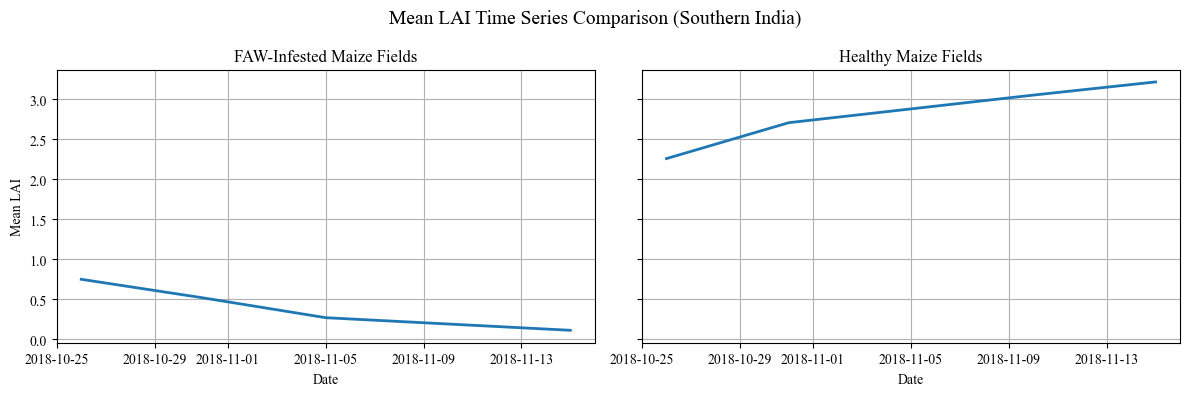

In [ ]:
scale = 10000

path_infested = "datasets/india_pest_time_series"
path_healthy  = "datasets/india_healthy_time_series"

dates_pest, lai_pest = compute_mean_lai_timeseries(path_infested, scale)
dates_healthy, lai_healthy = compute_mean_lai_timeseries(path_healthy, scale)

fig, axes = plt.subplots(
    nrows=1, ncols=2,
    figsize=(12, 4),
    sharey=True
)

# Pest-infested
axes[0].plot(dates_pest, lai_pest, linewidth=2)
axes[0].set_title("FAW-Infested Maize Fields")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Mean LAI")
axes[0].grid(True)

# Healthy
axes[1].plot(dates_healthy, lai_healthy, linewidth=2)
axes[1].set_title("Healthy Maize Fields")
axes[1].set_xlabel("Date")
axes[1].grid(True)

plt.suptitle("Mean LAI Time Series Comparison (Southern India)", fontsize=14)
plt.savefig("figures/india_lai_time_series_comparison.png", dpi=300)
plt.tight_layout()
plt.show()


Total number of files: 0


/tmp/ipykernel_117931/3199123770.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=8, ncol=2)


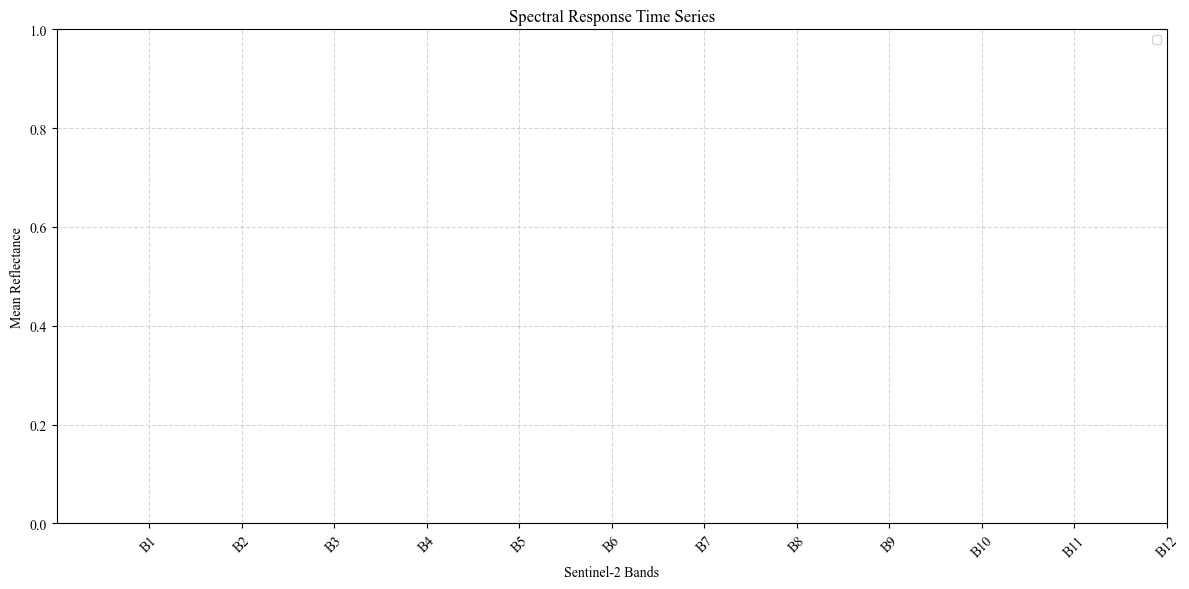

In [43]:
scale = 10000
path = "datasets/india_pest_time_series"

n_files, name_files = get_files_info(path)

spectral_ts = []
dates = []

for file in sorted(name_files):
    date = os.path.basename(file).split("_")[1].replace(".tif", "")
    dates.append(pd.to_datetime(date))

    with rasterio.open(os.path.join(path, file)) as src:
        img = src.read().astype(np.float32) / scale
        n_bands = img.shape[0]
        mean_spectrum = np.nanmean(img.reshape(n_bands, -1), axis=1)
        spectral_ts.append(mean_spectrum)

spectral_ts = np.array(spectral_ts)  # shape: [time, bands]

bands = np.arange(1, n_bands + 1)
band_labels = [f"B{i}" for i in bands]

plt.figure(figsize=(12, 6))

for i, date in enumerate(dates):
    plt.plot(
        bands,
        spectral_ts[i],
        marker="o",
        linewidth=1.5,
        alpha=0.6,
        label=date.strftime("%Y-%m-%d")
    )

plt.xticks(bands, band_labels, rotation=45)
plt.xlabel("Sentinel-2 Bands")
plt.ylabel("Mean Reflectance")
plt.title("Spectral Response Time Series")
plt.grid(True, linestyle="--", alpha=0.5)

# Optional: comment this if too many dates
plt.legend(fontsize=8, ncol=2)

plt.tight_layout()
plt.show()

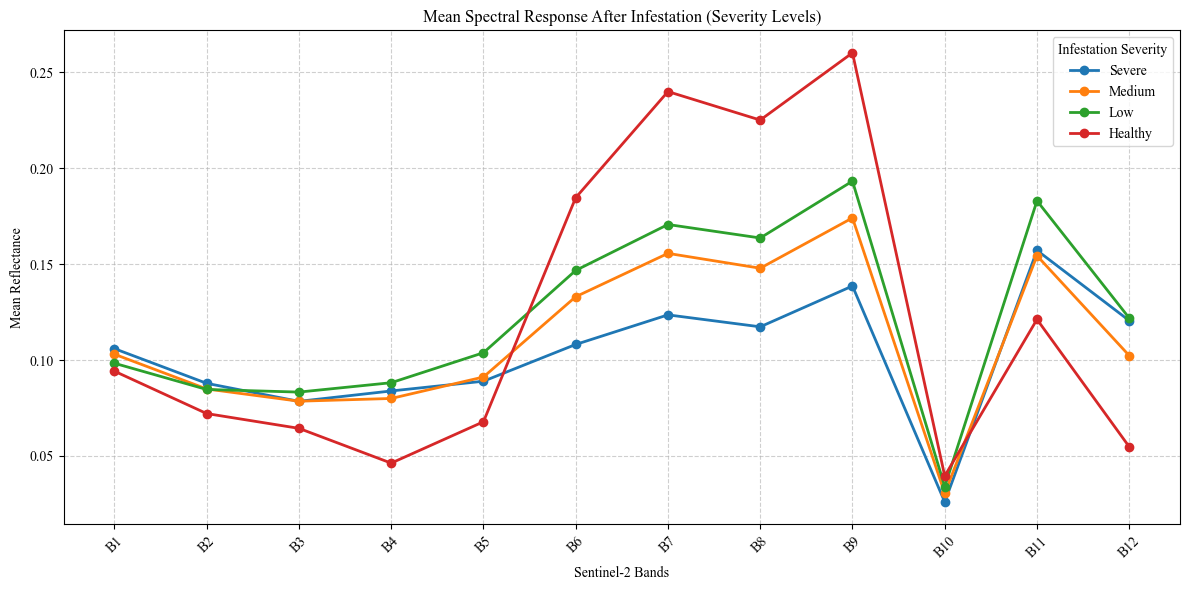

In [122]:
scale = 10000
path = "datasets/india_before_and_after"
conditions = ["severe", "medium", "low", "healthy"]

bands = np.arange(1, n_bands + 1)
band_labels = [f"B{i}" for i in bands]

plt.figure(figsize=(12, 6))

for condition in conditions:
    after_path = f"{path}/{condition}_after.tif"

    with rasterio.open(after_path) as src:
        img_after = src.read() / scale

    mean_after = np.nanmean(img_after.reshape(n_bands, -1), axis=1)

    plt.plot(
        bands, mean_after, "o-", linewidth=2,
        label=f"{condition.capitalize()}"
    )

plt.xticks(bands, band_labels, rotation=45)
plt.xlabel("Sentinel-2 Bands")
plt.ylabel("Mean Reflectance")
plt.title("Mean Spectral Response After Infestation (Severity Levels)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(title="Infestation Severity")
plt.tight_layout()
plt.show()


# Time-Series Smoothing

# Modeling

Total number of files: 4


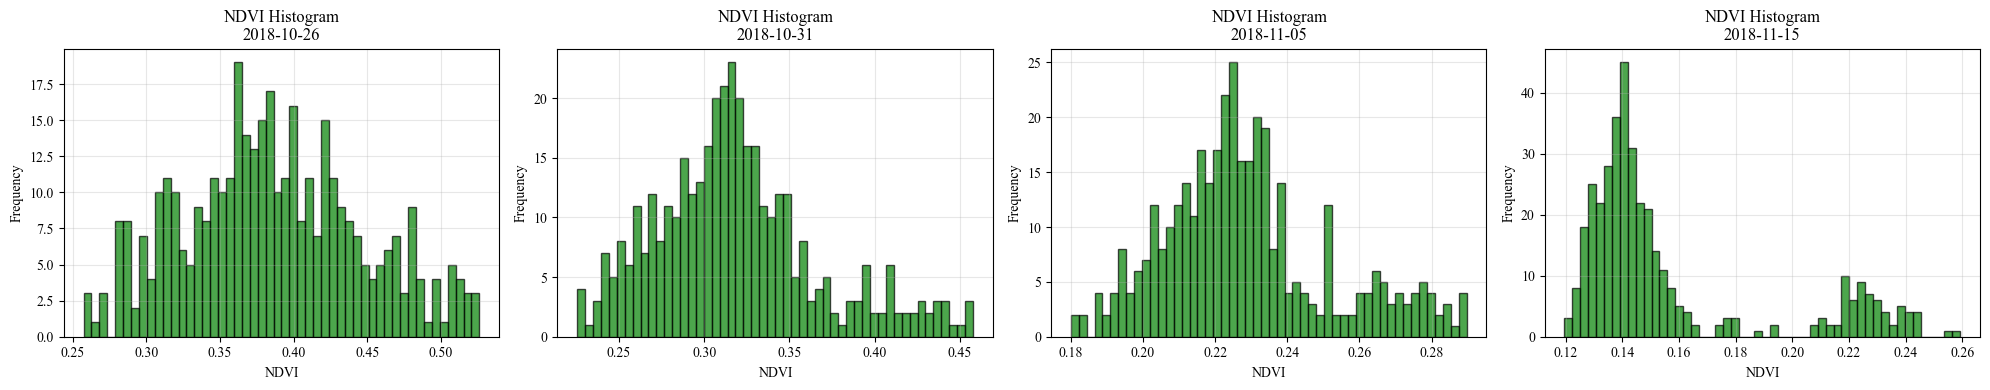

In [ ]:
path = "datasets/india_pest_time_series"
scale = 10000
n_clusters = 4  # Healthy, Low, Medium, Severe

n_files, name_files = get_files_info(path)
name_files = sorted(name_files)
ndvi_timeseries = []
dates = []
for file in name_files:
    date = os.path.basename(file).split("_")[1].replace(".tif", "")
    dates.append(pd.to_datetime(date))

# Create NDVI time series per pixel
for file in name_files:
    with rasterio.open(os.path.join(path, file)) as src:
        red = src.read(4).astype(np.float32) / scale
        nir = src.read(8).astype(np.float32) / scale
        nodata = src.nodata
        if nodata is not None:
            red = np.where(red == nodata, np.nan, red)
            nir = np.where(nir == nodata, np.nan, nir)
        
        denominator = nir + red
        ndvi = np.where(denominator != 0, (nir - red) / denominator, np.nan)
        
        ndvi_timeseries.append(ndvi)

ndvi_timeseries = np.array(ndvi_timeseries)
T, H, W = ndvi_timeseries.shape
ndvi_reshaped = ndvi_timeseries.reshape(T, -1).T

valid_mask = ~np.any(np.isnan(ndvi_reshaped), axis=1)
ndvi_valid = ndvi_reshaped[valid_mask]

fig, axes = plt.subplots(1, len(dates), figsize=(5*len(dates), 4))

for t in range(len(dates)):
    ndvi_t = ndvi_timeseries[t].flatten()
    ndvi_t_valid = ndvi_t[~np.isnan(ndvi_t)]
    
    axes[t].hist(ndvi_t_valid, bins=50, color='green', alpha=0.7, edgecolor='black')
    axes[t].set_xlabel('NDVI')
    axes[t].set_ylabel('Frequency')
    axes[t].set_title(f'NDVI Histogram\n{dates[t].strftime("%Y-%m-%d")}')
    axes[t].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Total number of files: 4


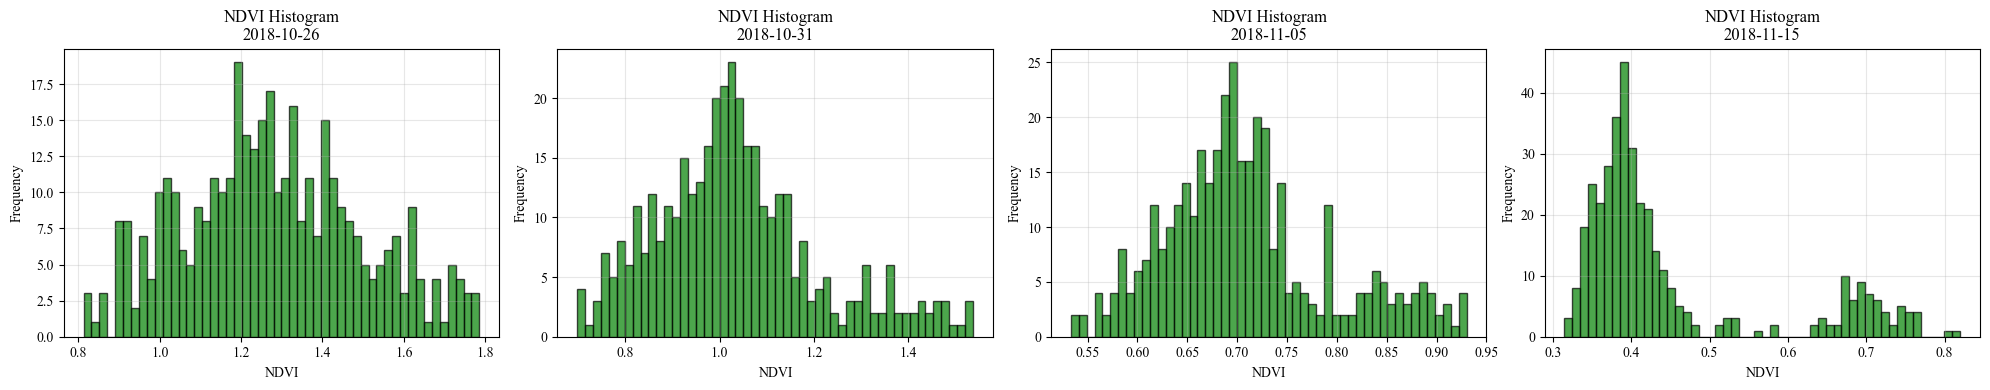

In [36]:
path = "datasets/india_pest_time_series"
scale = 10000
n_clusters = 4  # Healthy, Low, Medium, Severe

n_files, name_files = get_files_info(path)
name_files = sorted(name_files)
lai_timeseries = []
dates = []
for file in name_files:
    date = os.path.basename(file).split("_")[1].replace(".tif", "")
    dates.append(pd.to_datetime(date))

# Create NDVI time series per pixel
for file in name_files:
    with rasterio.open(os.path.join(path, file)) as src:
        red = src.read(4).astype(np.float32) / scale
        nir = src.read(8).astype(np.float32) / scale
        nodata = src.nodata
        if nodata is not None:
            red = np.where(red == nodata, np.nan, red)
            nir = np.where(nir == nodata, np.nan, nir)
        
        evi = (nir - red) / (nir + red + 1e-6)
        lai = 3.618 * evi - 0.118
        
        lai_timeseries.append(lai)

lai_timeseries = np.array(lai_timeseries)
T, H, W = lai_timeseries.shape
ndvi_reshaped = lai_timeseries.reshape(T, -1).T

valid_mask = ~np.any(np.isnan(ndvi_reshaped), axis=1)
ndvi_valid = ndvi_reshaped[valid_mask]

# Create histogram for each date without clustering
fig, axes = plt.subplots(1, len(dates), figsize=(5*len(dates), 4))

for t in range(len(dates)):
    ndvi_t = lai_timeseries[t].flatten()
    ndvi_t_valid = ndvi_t[~np.isnan(ndvi_t)]
    
    axes[t].hist(ndvi_t_valid, bins=50, color='green', alpha=0.7, edgecolor='black')
    axes[t].set_xlabel('NDVI')
    axes[t].set_ylabel('Frequency')
    axes[t].set_title(f'NDVI Histogram\n{dates[t].strftime("%Y-%m-%d")}')
    axes[t].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Total number of files: 4


/tmp/ipykernel_1264601/4116515199.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


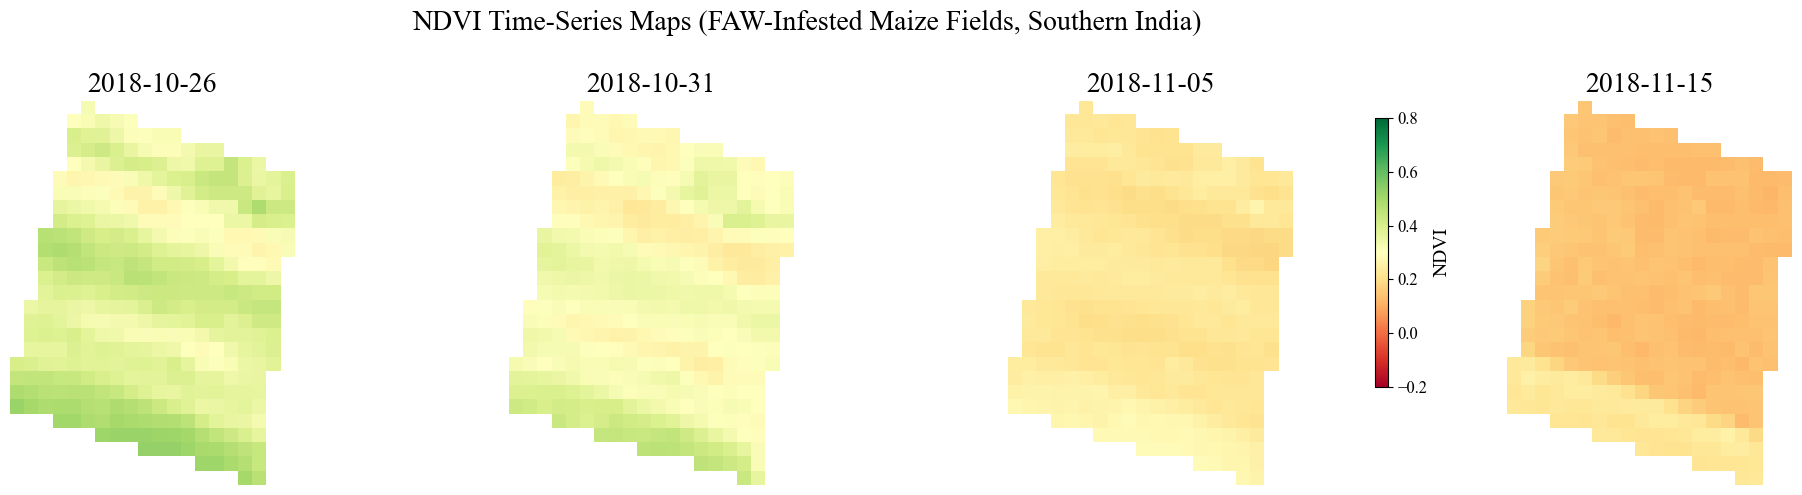

In [48]:
path = "datasets/india_pest_time_series"
scale = 10000

n_files, name_files = get_files_info(path)
name_files = sorted(name_files)

ndvi_maps = []
dates = []

for file in name_files:
    date = os.path.basename(file).split("_")[1].replace(".tif", "")
    dates.append(pd.to_datetime(date))

    with rasterio.open(os.path.join(path, file)) as src:
        red = src.read(4).astype(np.float32) / scale
        nir = src.read(8).astype(np.float32) / scale

        nodata = src.nodata
        if nodata is not None:
            red = np.where(red == nodata, np.nan, red)
            nir = np.where(nir == nodata, np.nan, nir)

        ndvi = (nir - red) / (nir + red)
        ndvi[(nir + red) == 0] = np.nan

        ndvi_maps.append(ndvi)

ndvi_maps = np.array(ndvi_maps)

n_images = len(ndvi_maps)
n_cols = 4
n_rows = int(np.ceil(n_images / n_cols))

fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(5 * n_cols, 5 * n_rows),  # <-- increased
    squeeze=False
)

for i, ax in enumerate(axes.flat):
    if i < n_images:
        im = ax.imshow(
            ndvi_maps[i],
            cmap="RdYlGn",
            vmin=-0.2,
            vmax=0.8
        )
        ax.set_title(
            dates[i].strftime("%Y-%m-%d"),
            fontsize=20,          
            pad=6
        )
        ax.axis("off")
    else:
        ax.axis("off")
cbar = fig.colorbar(
    im,
    ax=axes.ravel().tolist(),
    shrink=0.7,
    pad=0.02
)
cbar.set_label("NDVI", fontsize=14)
cbar.ax.tick_params(labelsize=12)

plt.suptitle(
    "NDVI Time-Series Maps (FAW-Infested Maize Fields, Southern India)",
    fontsize=20,
    y=0.98
)

plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.savefig(
    "figures/india_ndvi_time_series_maps.png",
    dpi=300,
    bbox_inches="tight"
)
plt.show()


Total number of files: 4


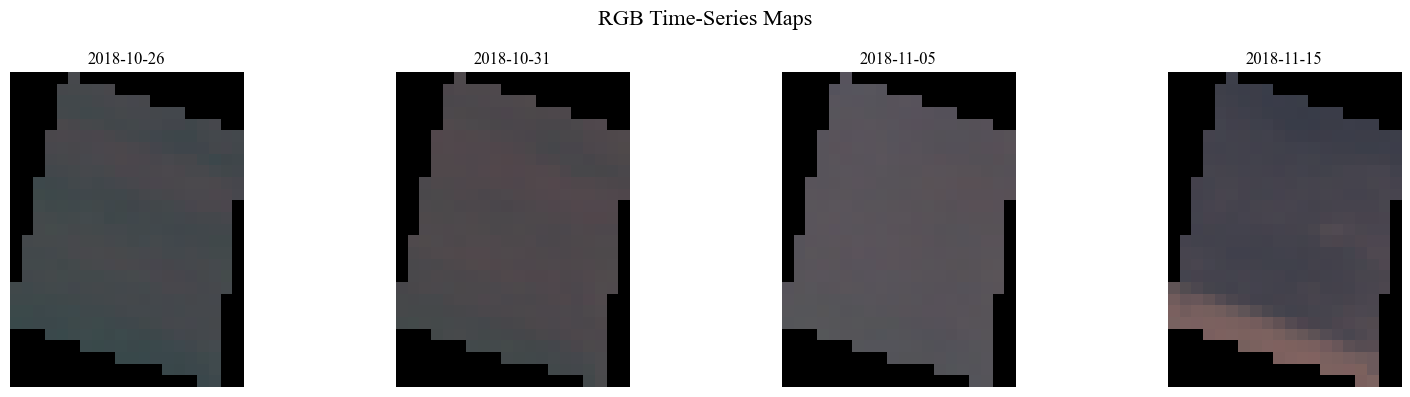

In [ ]:
path = "datasets/india_pest_time_series"
scale = 5000

n_files, name_files = get_files_info(path)
name_files = sorted(name_files)

rgb_maps = []
dates = []

for file in name_files:
    date = os.path.basename(file).split("_")[1].replace(".tif", "")
    dates.append(pd.to_datetime(date))

    with rasterio.open(os.path.join(path, file)) as src:
        red = src.read(4).astype(np.float32) / scale
        green = src.read(3).astype(np.float32) / scale
        blue = src.read(2).astype(np.float32) / scale

        nodata = src.nodata
        if nodata is not None:
            red = np.where(red == nodata, 0, red)
            green = np.where(green == nodata, 0, green)
            blue = np.where(blue == nodata, 0, blue)

        rgb = np.dstack([red, green, blue])
        rgb_maps.append(rgb)

rgb_maps = np.array(rgb_maps)

n_images = len(rgb_maps)
n_cols = 4
n_rows = int(np.ceil(n_images / n_cols))

fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(4 * n_cols, 4 * n_rows),
    squeeze=False
)

for i, ax in enumerate(axes.flat):
    if i < n_images:
        ax.imshow(rgb_maps[i])
        ax.set_title(dates[i].strftime("%Y-%m-%d"))
        ax.axis("off")
    else:
        ax.axis("off")

plt.suptitle("RGB Time-Series Maps", fontsize=16)
plt.tight_layout()
plt.show()


Total number of files: 4


/tmp/ipykernel_1429734/1261394428.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


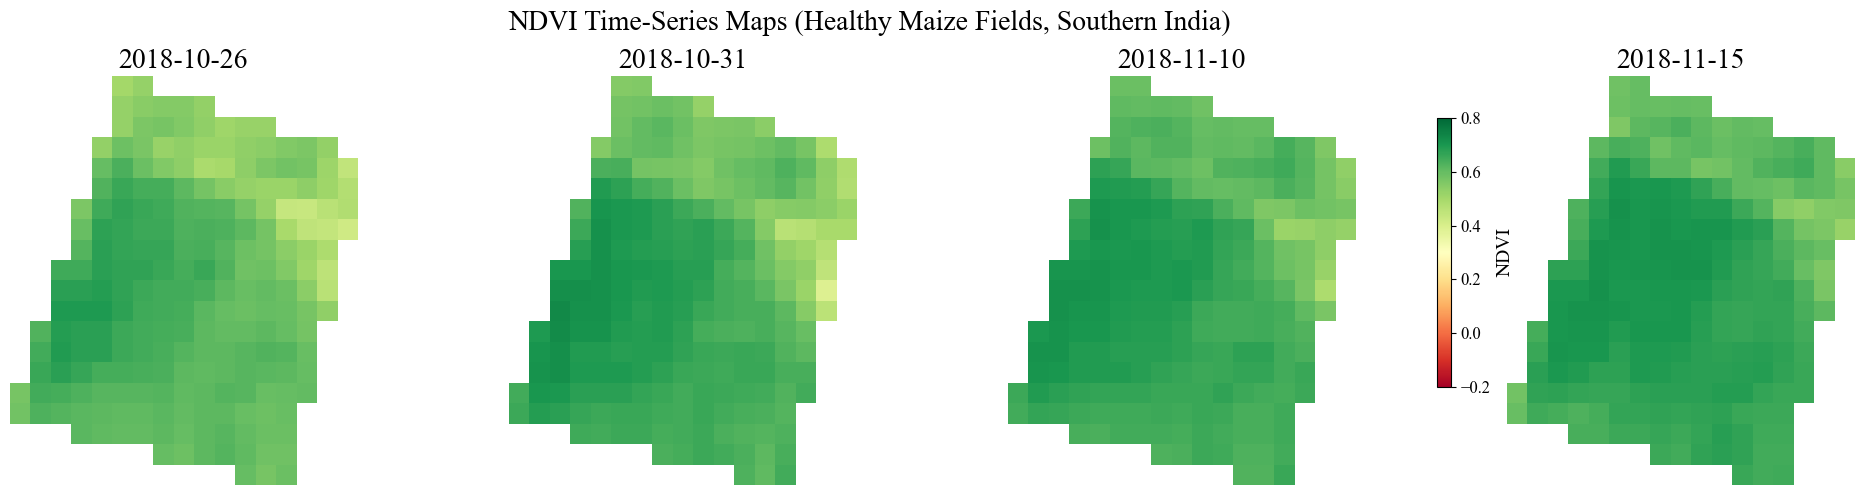

In [29]:
path = "datasets/india_healthy_time_series"
scale = 10000

n_files, name_files = get_files_info(path)
name_files = sorted(name_files)

ndvi_maps = []
dates = []

for file in name_files:
    date = os.path.basename(file).split("_")[1].replace(".tif", "")
    dates.append(pd.to_datetime(date))

    with rasterio.open(os.path.join(path, file)) as src:
        red = src.read(4).astype(np.float32) / scale
        nir = src.read(8).astype(np.float32) / scale

        nodata = src.nodata
        if nodata is not None:
            red = np.where(red == nodata, np.nan, red)
            nir = np.where(nir == nodata, np.nan, nir)

        ndvi = (nir - red) / (nir + red)
        ndvi[(nir + red) == 0] = np.nan

        ndvi_maps.append(ndvi)

ndvi_maps = np.array(ndvi_maps)

n_images = len(ndvi_maps)
n_cols = 4
n_rows = int(np.ceil(n_images / n_cols))

fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(5 * n_cols, 5 * n_rows),  # <-- increased
    squeeze=False
)

for i, ax in enumerate(axes.flat):
    if i < n_images:
        im = ax.imshow(
            ndvi_maps[i],
            cmap="RdYlGn",
            vmin=-0.2,
            vmax=0.8
        )
        ax.set_title(
            dates[i].strftime("%Y-%m-%d"),
            fontsize=20,           # <-- larger title font
            pad=6
        )
        ax.axis("off")
    else:
        ax.axis("off")

cbar = fig.colorbar(
    im,
    ax=axes.ravel().tolist(),
    shrink=0.7,
    pad=0.02
)
cbar.set_label("NDVI", fontsize=14)
cbar.ax.tick_params(labelsize=12)

plt.suptitle(
    "NDVI Time-Series Maps (Healthy Maize Fields, Southern India)",
    fontsize=20,
    y=0.98
)

plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.savefig(
    "figures/india_ndvi_time_series_maps_healthy.png",
    dpi=300,
    bbox_inches="tight"
)
plt.show()


Total number of files: 4


/tmp/ipykernel_1429734/1537866862.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


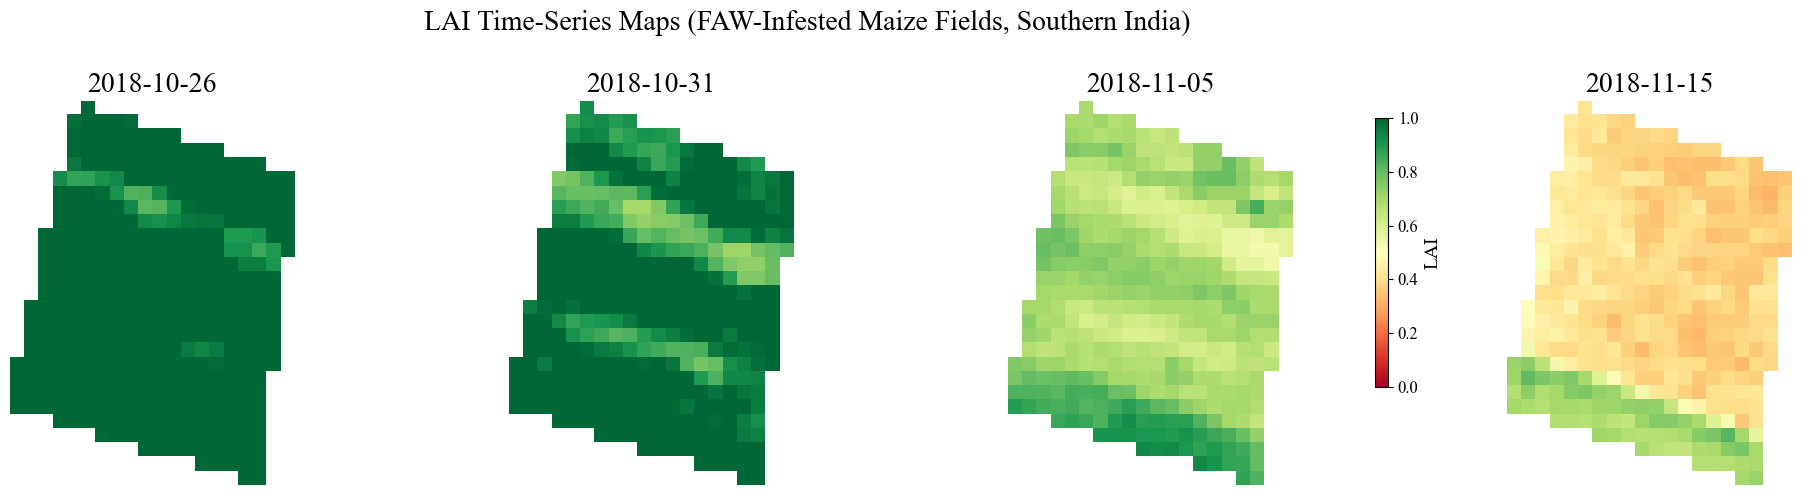

In [28]:
path = "datasets/india_pest_time_series"
scale = 10000

n_files, name_files = get_files_info(path)
name_files = sorted(name_files)

lai_maps = []
dates = []

for file in name_files:
    date = os.path.basename(file).split("_")[1].replace(".tif", "")
    dates.append(pd.to_datetime(date))

    with rasterio.open(os.path.join(path, file)) as src:
        red = src.read(4).astype(np.float32) / scale  # B4
        nir = src.read(8).astype(np.float32) / scale  # B8

        nodata = src.nodata
        if nodata is not None:
            mask = (red == nodata) | (nir == nodata)
            red = np.where(mask, np.nan, red)
            nir = np.where(mask, np.nan, nir)

        evi = (nir - red) / (nir + red + 1e-6)

        lai = 3.618 * evi - 0.118
        lai_maps.append(lai)

lai_maps = np.array(lai_maps)

n_images = len(lai_maps)
n_cols = 4
n_rows = int(np.ceil(n_images / n_cols))

fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(5 * n_cols, 5 * n_rows),
    squeeze=False
)

for i, ax in enumerate(axes.flat):
    if i < n_images:
        im = ax.imshow(
            lai_maps[i],
            cmap="RdYlGn",
            vmin=0,      # Adjust as needed
            vmax=1
        )
        ax.set_title(
            dates[i].strftime("%Y-%m-%d"),
            fontsize=20,
            pad=6
        )
        ax.axis("off")
    else:
        ax.axis("off")

cbar = fig.colorbar(
    im,
    ax=axes.ravel().tolist(),
    shrink=0.7,
    pad=0.02
)
cbar.set_label("LAI", fontsize=14)
cbar.ax.tick_params(labelsize=12)

plt.suptitle(
    "LAI Time-Series Maps (FAW-Infested Maize Fields, Southern India)",
    fontsize=20,
    y=0.98
)

plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.savefig(
    "figures/india_lai_time_series_maps.png",
    dpi=300,
    bbox_inches="tight"
)
plt.show()


Total number of files: 4


/tmp/ipykernel_1429734/391829045.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


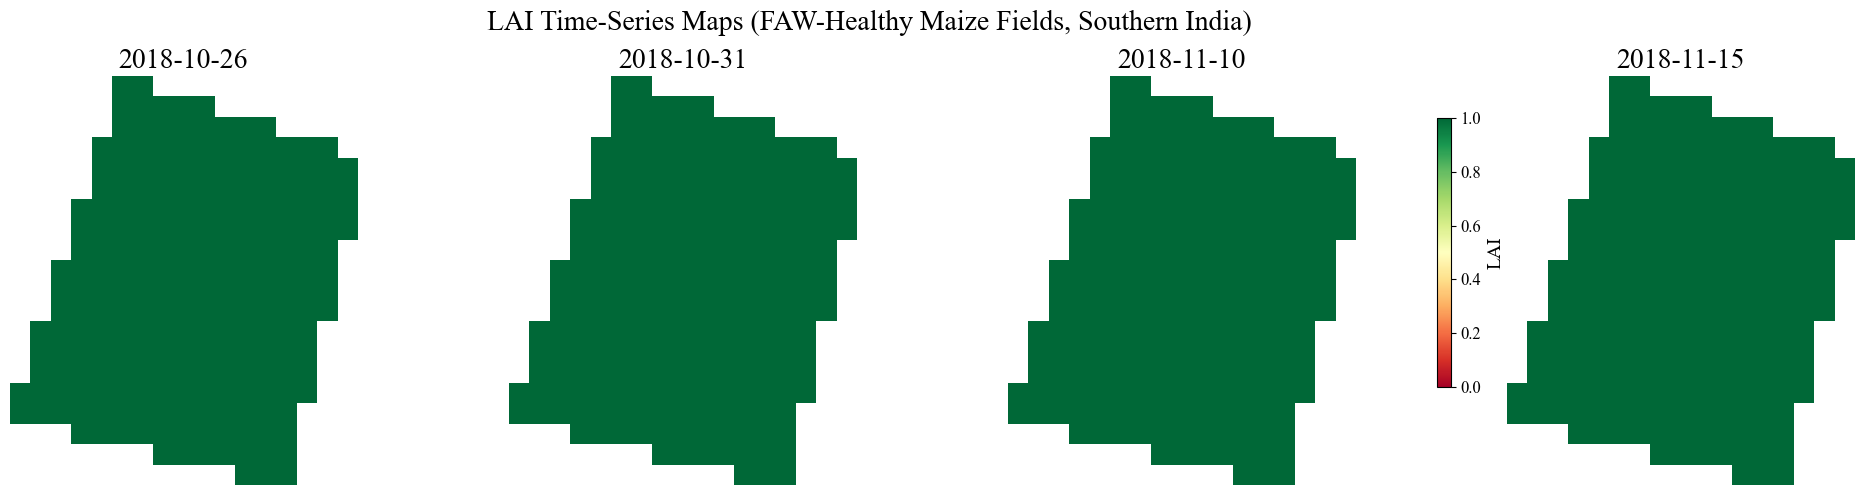

In [27]:
path = "datasets/india_healthy_time_series"
scale = 10000

n_files, name_files = get_files_info(path)
name_files = sorted(name_files)

lai_maps = []
dates = []

for file in name_files:
    date = os.path.basename(file).split("_")[1].replace(".tif", "")
    dates.append(pd.to_datetime(date))

    with rasterio.open(os.path.join(path, file)) as src:
        red = src.read(4).astype(np.float32) / scale  # B4
        nir = src.read(8).astype(np.float32) / scale  # B8

        nodata = src.nodata
        if nodata is not None:
            mask = (red == nodata) | (nir == nodata)
            red = np.where(mask, np.nan, red)
            nir = np.where(mask, np.nan, nir)

        evi = (nir - red) / (nir + red + 1e-6)

        lai = 3.618 * evi - 0.118
        lai_maps.append(lai)

lai_maps = np.array(lai_maps)

n_images = len(lai_maps)
n_cols = 4
n_rows = int(np.ceil(n_images / n_cols))

fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(5 * n_cols, 5 * n_rows),
    squeeze=False
)

for i, ax in enumerate(axes.flat):
    if i < n_images:
        im = ax.imshow(
            lai_maps[i],
            cmap="RdYlGn",
            vmin=0,      # Adjust as needed
            vmax=1
        )
        ax.set_title(
            dates[i].strftime("%Y-%m-%d"),
            fontsize=20,
            pad=6
        )
        ax.axis("off")
    else:
        ax.axis("off")

cbar = fig.colorbar(
    im,
    ax=axes.ravel().tolist(),
    shrink=0.7,
    pad=0.02
)
cbar.set_label("LAI", fontsize=14)
cbar.ax.tick_params(labelsize=12)

plt.suptitle(
    "LAI Time-Series Maps (FAW-Healthy Maize Fields, Southern India)",
    fontsize=20,
    y=0.98
)

plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.savefig(
    "figures/india_lai_time_series_maps_healthy.png",
    dpi=300,
    bbox_inches="tight"
)
plt.show()
